In [ ]:
# Célula 1: Título do Projeto e Introdução

# Título do Projeto: Sistema de Gerenciamento de Bens Patrimoniais com MongoDB
# Disciplina: Banco de Dados Não Relacional - UTFPR
# Professor(a): Kelly Lais Wiggers
# Aluno(a): João Abner Pereira de Almeida
# Data de Entrega: 26/06/2025

"""
Objetivo do Projeto:
Este projeto final tem como objetivo desenvolver um sistema de armazenamento 
e consulta de dados patrimoniais utilizando MongoDB e Python.

Ele simula o backend de um aplicativo de gestão de patrimônio, permitindo:

1.  Armazenar dados de bens patrimoniais (com base em um dataset público).
2.  Registrar movimentações (simulando a leitura de códigos de barras com 'asset_id').
3.  Realizar operações CRUD (Criar, Ler, Atualizar, Excluir) exigidas pela disciplina.
4.  Executar consultas com diferentes operadores e funções de agregação.
5.  Realizar análise exploratória de dados com Pandas.
6.  Gerar relatórios visuais simples.

Este sistema é relevante para um aplicativo de Gestão de Patrimônio da UTFPR,
focado em substituir planilhas manuais, reduzir erros e agilizar inventários.
"""

print("Iniciando a demonstração do Projeto Final de Banco de Dados Não Relacional...")

Iniciando a demonstração do Projeto Final de Banco de Dados Não Relacional...


In [ ]:
# Célula 2: Importações de Bibliotecas e Configurações Iniciais

import pandas as pd
from pymongo import MongoClient
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Adiciona importação para display

# --- CONFIGURAÇÃO DO MONGO DB ---
MONGO_URI = "mongodb://localhost:27017/"
DB_NAME = "patrimonio_db"
COLLECTION_NAME = "bens"

# Caminho para o arquivo CSV do dataset "Universal Product Code Database" do Kaggle. 
CSV_FILE_PATH = "products.csv"

print("Bibliotecas importadas e configurações iniciais definidas.")
print(f"MongoDB URI: {MONGO_URI}")
print(f"Banco de Dados: {DB_NAME}, Coleção: {COLLECTION_NAME}")
print(f"Caminho do CSV: {CSV_FILE_PATH}")

Bibliotecas importadas e configurações iniciais definidas.
MongoDB URI: mongodb://localhost:27017/
Banco de Dados: patrimonio_db, Coleção: bens
Caminho do CSV: products.csv


In [3]:
# Célula 3: Função de Conexão com MongoDB (Item 2)

def conectar_mongodb():
    """
    Estabelece a conexão com o MongoDB.
    Retorna o objeto da coleção para interação ou None em caso de erro.

    Item 2: Define a forma de conexão e acesso aos dados no MongoDB.
    """
    try:
        client = MongoClient(MONGO_URI)
        db = client[DB_NAME]
        collection = db[COLLECTION_NAME]
        # Tentativa de comando 'ping' para verificar se a conexão está ativa.
        client.admin.command('ping')
        print(f"Conectado com sucesso ao MongoDB: Banco '{DB_NAME}', Coleção '{COLLECTION_NAME}'.")
        return collection
    except Exception as e:
        print(f"ERRO: Não foi possível conectar ao MongoDB. Verifique se o servidor MongoDB está em execução em '{MONGO_URI}'.")
        print(f"Detalhes do erro: {e}")
        return None

# Tentando conectar ao MongoDB
bens_collection = conectar_mongodb()

Conectado com sucesso ao MongoDB: Banco 'patrimonio_db', Coleção 'bens'.


In [4]:
# Célula 4: Função de Importação de Dados do CSV para MongoDB (Itens 2a, 2b, 2c)

def importar_csv_para_mongodb(collection, csv_path, num_registros=100):
    """
    Importa dados de um arquivo CSV para a coleção MongoDB.
    Limita o número de registros para agilizar o projeto.
    Mapeia campos do dataset original para o modelo de bens patrimoniais.

    Item 2a: Utiliza base de dados pública (products.csv do Kaggle).
    Item 2b: Converte dados para formato JSON compatível com MongoDB.
    Item 2c: Importa os dados para manipulação no Jupyter Notebook (via MongoDB).
    """
    if not os.path.exists(csv_path):
        print(f"ERRO: Arquivo CSV '{csv_path}' não encontrado. Por favor, verifique o caminho.")
        return

    try:
        df = pd.read_csv(csv_path, low_memory=False)
        print(f"CSV '{csv_path}' carregado. Total de registros no arquivo: {len(df)}.")

        # Seleciona uma amostra para o projeto (ajustável).
        df_sample = df.head(num_registros) if len(df) > num_registros else df
        print(f"Processando e importando {len(df_sample)} registros para o MongoDB.")

        documents = []
        for index, row in df_sample.iterrows():
            doc = {
                "asset_id": str(row.get("product_id", f"UNKNOWN_ID_{index}")), # product_id como asset_id
                "asset_name": str(row.get("product_name", "Nome Desconhecido")),
                "category": str(row.get("category", "Geral")),
                "brand": str(row.get("brand", "Não Informada")),
                "description": str(row.get("description", "Sem descrição.")),
                "location": "Armazenagem Principal", # Valor inicial
                "status": "Em Uso", # Valor inicial
                "acquisition_date": pd.to_datetime('2023-01-01').strftime('%Y-%m-%d'),
                "movement_history": [
                    {
                        "date": pd.to_datetime('2023-01-01 00:00:00').strftime('%Y-%m-%d %H:%M:%S'),
                        "type": "Aquisição",
                        "from_location": "Fornecedor",
                        "to_location": "Armazenagem Principal",
                        "responsible": "Sistema Inicial"
                    }
                ]
            }
            documents.append(doc)

        # Limpa a coleção para evitar duplicatas em cada execução e insere os novos documentos.
        collection.delete_many({})
        if documents:
            result = collection.insert_many(documents)
            print(f"{len(result.inserted_ids)} documentos importados com sucesso para o MongoDB na coleção '{COLLECTION_NAME}'.")
        else:
            print("Nenhum documento válido para importar.")

    except Exception as e:
        print(f"ERRO ao importar CSV para MongoDB: {e}")

# Executa a importação dos dados se a conexão for bem-sucedida
if bens_collection is not None:
    importar_csv_para_mongodb(bens_collection, CSV_FILE_PATH, num_registros=100)

CSV 'products.csv' carregado. Total de registros no arquivo: 1048575.
Processando e importando 100 registros para o MongoDB.
100 documentos importados com sucesso para o MongoDB na coleção 'bens'.


In [5]:
# Célula 5: Função para Apresentar Dados como DataFrame (Item 2d)

from IPython.display import display

def apresentar_dados_como_dataframe(collection, limit=10):
    """
    Busca documentos da coleção MongoDB e os apresenta como um DataFrame do Pandas.
    Exibe a coluna movement_history de forma mais legível.
    Item 2d: Apresenta os dados como DataFrame.
    """
    try:
        cursor = collection.find().limit(limit)
        data = list(cursor)

        if data:
            df = pd.DataFrame(data)
            if '_id' in df.columns:
                df = df.drop(columns=['_id']) # Remove o ID interno do MongoDB para melhor visualização
            # Formata a coluna movement_history para exibição mais amigável
            if 'movement_history' in df.columns:
                def format_history(hist):
                    if isinstance(hist, list) and len(hist) > 0:
                        last = hist[-1]
                        return f"{last.get('date', '')} | {last.get('type', '')} | {last.get('from_location', '')} → {last.get('to_location', '')}"
                    return ""
                df['Última Movimentação'] = df['movement_history'].apply(format_history)
            pd.set_option('display.max_colwidth', 120)
            pd.set_option('display.width', 1000)
            print(f"\n--- Primeiros {len(df)} documentos da coleção '{COLLECTION_NAME}' como DataFrame ---")
            display(df)
            return df
        else:
            print(f"Nenhum documento encontrado na coleção '{COLLECTION_NAME}'.")
            return pd.DataFrame()
    except Exception as e:
        print(f"ERRO ao apresentar dados como DataFrame: {e}")
        return pd.DataFrame()

# Apresenta uma amostra dos dados recém-importados como DataFrame
if bens_collection is not None:
    df_patrimonio = apresentar_dados_como_dataframe(bens_collection, limit=15) # Exibe mais para demonstração


--- Primeiros 15 documentos da coleção 'bens' como DataFrame ---


,asset_id,asset_name,category,brand,description,location,status,acquisition_date,movement_history,Última Movimentação
0,UNKNOWN_ID_0,Nome Desconhecido,Geral,Não Informada,Sem descrição.,Armazenagem Principal,Em Uso,2023-01-01,"[{'date': '2023-01-01 00:00:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Armazenagem Pri...",2023-01-01 00:00:00 | Aquisição | Fornecedor → Armazenagem Principal
1,UNKNOWN_ID_1,Nome Desconhecido,Geral,Não Informada,Sem descrição.,Armazenagem Principal,Em Uso,2023-01-01,"[{'date': '2023-01-01 00:00:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Armazenagem Pri...",2023-01-01 00:00:00 | Aquisição | Fornecedor → Armazenagem Principal
2,UNKNOWN_ID_2,Nome Desconhecido,Geral,Não Informada,Sem descrição.,Armazenagem Principal,Em Uso,2023-01-01,"[{'date': '2023-01-01 00:00:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Armazenagem Pri...",2023-01-01 00:00:00 | Aquisição | Fornecedor → Armazenagem Principal
3,UNKNOWN_ID_3,Nome Desconhecido,Geral,Não Informada,Sem descrição.,Armazenagem Principal,Em Uso,2023-01-01,"[{'date': '2023-01-01 00:00:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Armazenagem Pri...",2023-01-01 00:00:00 | Aquisição | Fornecedor → Armazenagem Principal
4,UNKNOWN_ID_4,Nome Desconhecido,Geral,Não Informada,Sem descrição.,Armazenagem Principal,Em Uso,2023-01-01,"[{'date': '2023-01-01 00:00:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Armazenagem Pri...",2023-01-01 00:00:00 | Aquisição | Fornecedor → Armazenagem Principal
5,UNKNOWN_ID_5,Nome Desconhecido,Geral,Não Informada,Sem descrição.,Armazenagem Principal,Em Uso,2023-01-01,"[{'date': '2023-01-01 00:00:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Armazenagem Pri...",2023-01-01 00:00:00 | Aquisição | Fornecedor → Armazenagem Principal
6,UNKNOWN_ID_6,Nome Desconhecido,Geral,Não Informada,Sem descrição.,Armazenagem Principal,Em Uso,2023-01-01,"[{'date': '2023-01-01 00:00:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Armazenagem Pri...",2023-01-01 00:00:00 | Aquisição | Fornecedor → Armazenagem Principal
7,UNKNOWN_ID_7,Nome Desconhecido,Geral,Não Informada,Sem descrição.,Armazenagem Principal,Em Uso,2023-01-01,"[{'date': '2023-01-01 00:00:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Armazenagem Pri...",2023-01-01 00:00:00 | Aquisição | Fornecedor → Armazenagem Principal
8,UNKNOWN_ID_8,Nome Desconhecido,Geral,Não Informada,Sem descrição.,Armazenagem Principal,Em Uso,2023-01-01,"[{'date': '2023-01-01 00:00:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Armazenagem Pri...",2023-01-01 00:00:00 | Aquisição | Fornecedor → Armazenagem Principal
9,UNKNOWN_ID_9,Nome Desconhecido,Geral,Não Informada,Sem descrição.,Armazenagem Principal,Em Uso,2023-01-01,"[{'date': '2023-01-01 00:00:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Armazenagem Pri...",2023-01-01 00:00:00 | Aquisição | Fornecedor → Armazenagem Principal


In [6]:
# Célula 6: Demonstração de Inserção de Dados (Item 3b)
from IPython.display import display

def inserir_documento_extra(collection, num_docs=5):
    """
    Insere 'num_docs' documentos de dados extras na coleção, simulando novos bens.
    Item 3b: Em cada coleção, insira 5 documentos de dados extras.
    """
    new_assets = []
    current_count = collection.count_documents({})
    for i in range(num_docs):
        asset_id_new = f"NEWASSET{current_count + 1 + i}"
        new_asset = {
            "asset_id": asset_id_new,
            "asset_name": f"Monitor 27 polegadas {i+1}",
            "category": "Eletrônico",
            "brand": "TechBrand",
            "description": f"Monitor de alta resolução para estação de trabalho {i+1}.",
            "location": "Sala de Reuniões",
            "status": "Ativo",
            "acquisition_date": pd.to_datetime('2024-05-20').strftime('%Y-%m-%d'),
            "movement_history": [
                {
                    "date": pd.to_datetime('2024-05-20 09:30:00').strftime('%Y-%m-%d %H:%M:%S'),
                    "type": "Aquisição",
                    "from_location": "Fornecedor",
                    "to_location": "Sala de Reuniões",
                    "responsible": "Gerência de TI"
                }
            ]
        }
        new_assets.append(new_asset)
    try:
        result = collection.insert_many(new_assets)
        print(f"\nINSERÇÃO: Inseridos {len(result.inserted_ids)} documentos extras na coleção.")
        # Exibe os novos documentos inseridos de forma resumida
        display(pd.DataFrame(new_assets))
        return result.inserted_ids
    except Exception as e:
        print(f"ERRO ao inserir documentos extras: {e}")
        return []

# Executa a inserção de 5 documentos extras
if bens_collection is not None:
    inserted_ids_extras = inserir_documento_extra(bens_collection, num_docs=5)


INSERÇÃO: Inseridos 5 documentos extras na coleção.


,asset_id,asset_name,category,brand,description,location,status,acquisition_date,movement_history,_id
0,NEWASSET101,Monitor 27 polegadas 1,Eletrônico,TechBrand,Monitor de alta resolução para estação de trabalho 1.,Sala de Reuniões,Ativo,2024-05-20,"[{'date': '2024-05-20 09:30:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Sala de Reuniõe...",685dbd13b5824815ad710cfd
1,NEWASSET102,Monitor 27 polegadas 2,Eletrônico,TechBrand,Monitor de alta resolução para estação de trabalho 2.,Sala de Reuniões,Ativo,2024-05-20,"[{'date': '2024-05-20 09:30:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Sala de Reuniõe...",685dbd13b5824815ad710cfe
2,NEWASSET103,Monitor 27 polegadas 3,Eletrônico,TechBrand,Monitor de alta resolução para estação de trabalho 3.,Sala de Reuniões,Ativo,2024-05-20,"[{'date': '2024-05-20 09:30:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Sala de Reuniõe...",685dbd13b5824815ad710cff
3,NEWASSET104,Monitor 27 polegadas 4,Eletrônico,TechBrand,Monitor de alta resolução para estação de trabalho 4.,Sala de Reuniões,Ativo,2024-05-20,"[{'date': '2024-05-20 09:30:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Sala de Reuniõe...",685dbd13b5824815ad710d00
4,NEWASSET105,Monitor 27 polegadas 5,Eletrônico,TechBrand,Monitor de alta resolução para estação de trabalho 5.,Sala de Reuniões,Ativo,2024-05-20,"[{'date': '2024-05-20 09:30:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Sala de Reuniõe...",685dbd13b5824815ad710d01


In [7]:
# Célula 7: Demonstração de Edição de Dados (Item 3c)
from IPython.display import display

def editar_documento(collection, asset_id, new_location=None, new_status=None):
    """
    Edita a localização ou status de um bem, simulando uma movimentação ou atualização.
    Adiciona a movimentação ao histórico do bem.

    Item 3c: Edita 2 opções diferentes de dados (independente do documento).
    """
    update_fields = {}
    current_time = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    movement_entry = {
        "date": current_time,
        "type": "Movimentação",
        "responsible": "Usuário App"
    }

    current_asset = collection.find_one({"asset_id": asset_id})
    if not current_asset:
        print(f"AVISO: Bem '{asset_id}' não encontrado para edição.")
        return

    if new_location and new_location != current_asset.get("location"):
        old_location = current_asset.get("location", "Desconhecida")
        update_fields["location"] = new_location
        movement_entry["from_location"] = old_location
        movement_entry["to_location"] = new_location
        movement_entry["type"] = "Mudança de Localização"
        print(f"Atualizando localização do bem '{asset_id}' de '{old_location}' para '{new_location}'.")

    if new_status and new_status != current_asset.get("status"):
        old_status = current_asset.get("status", "Desconhecido")
        update_fields["status"] = new_status
        if not new_location: # Se só o status mudar, adapta o tipo de movimentação
             movement_entry["type"] = f"Atualização de Status: {old_status} para {new_status}"
             movement_entry["from_location"] = current_asset.get("location", "Desconhecida")
             movement_entry["to_location"] = current_asset.get("location", "Desconhecida") # Mantém localização

        print(f"Atualizando status do bem '{asset_id}' de '{old_status}' para '{new_status}'.")

    try:
        result = collection.update_one(
            {"asset_id": asset_id},
            {
                "$set": update_fields,
                "$push": {"movement_history": movement_entry}
            }
        )
        if result.modified_count > 0:
            print(f"EDIÇÃO: Bem '{asset_id}' editado com sucesso e histórico de movimentação atualizado.")
            # Exibe o documento atualizado de forma amigável
            doc = collection.find_one({"asset_id": asset_id})
            if doc:
                df = pd.DataFrame([doc])
                if '_id' in df.columns:
                    df = df.drop(columns=['_id'])
                display(df)
        else:
            print(f"EDIÇÃO: Bem '{asset_id}' não foi alterado (dados iguais ou nenhum campo para editar).")
    except Exception as e:
        print(f"ERRO ao editar documento: {e}")

# Demonstração de edição (precisamos de asset_ids existentes)
if bens_collection is not None:
    # 1. Editar um item do dataset original
    sample_asset_1 = bens_collection.find_one({"asset_name": {"$ne": "Monitor 27 polegadas 1"}}) # Pega um que não seja dos extras
    if sample_asset_1:
        asset_to_edit_1 = sample_asset_1['asset_id']
        print(f"\nEDITANDO: Bem '{asset_to_edit_1}' (do dataset original)...")
        editar_documento(bens_collection, asset_to_edit_1, new_location="Reitoria - Sala A", new_status="Em Manutenção")
    else:
        print("\nAVISO: Não foi possível encontrar um bem do dataset original para editar.")

    # 2. Editar um item recém-inserido (se houver)
    if inserted_ids_extras:
        asset_to_edit_2_doc = bens_collection.find_one({"_id": inserted_ids_extras[0]})
        if asset_to_edit_2_doc:
            asset_to_edit_2 = asset_to_edit_2_doc['asset_id']
            print(f"\nEDITANDO: Bem '{asset_to_edit_2}' (recém-inserido)...")
            editar_documento(bens_collection, asset_to_edit_2, new_status="Desativado") # Altera apenas o status
        else:
            print("\nAVISO: Não foi possível encontrar o primeiro bem recém-inserido para editar.")
    else:
        print("\nAVISO: Nenhum documento extra foi inserido para demonstração de edição.")


EDITANDO: Bem 'UNKNOWN_ID_0' (do dataset original)...
Atualizando localização do bem 'UNKNOWN_ID_0' de 'Armazenagem Principal' para 'Reitoria - Sala A'.
Atualizando status do bem 'UNKNOWN_ID_0' de 'Em Uso' para 'Em Manutenção'.
EDIÇÃO: Bem 'UNKNOWN_ID_0' editado com sucesso e histórico de movimentação atualizado.


,asset_id,asset_name,category,brand,description,location,status,acquisition_date,movement_history
0,UNKNOWN_ID_0,Nome Desconhecido,Geral,Não Informada,Sem descrição.,Reitoria - Sala A,Em Manutenção,2023-01-01,"[{'date': '2023-01-01 00:00:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Armazenagem Pri..."



EDITANDO: Bem 'NEWASSET101' (recém-inserido)...
Atualizando status do bem 'NEWASSET101' de 'Ativo' para 'Desativado'.
EDIÇÃO: Bem 'NEWASSET101' editado com sucesso e histórico de movimentação atualizado.


,asset_id,asset_name,category,brand,description,location,status,acquisition_date,movement_history
0,NEWASSET101,Monitor 27 polegadas 1,Eletrônico,TechBrand,Monitor de alta resolução para estação de trabalho 1.,Sala de Reuniões,Desativado,2024-05-20,"[{'date': '2024-05-20 09:30:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Sala de Reuniõe..."


In [8]:
# Célula 8: Demonstração de Busca por Todos os Documentos (Item 3d)

def buscar_todos_documentos(collection):
    """
    Busca e retorna todos os documentos de uma coleção.
    Item 3d: Permite realizar a busca por todos os documentos de cada coleção.
    """
    print(f"\n--- BUSCA: Todos os documentos na coleção '{COLLECTION_NAME}' ---")
    try:
        documents = list(collection.find({}))
        if documents:
            for doc in documents:
                print(doc)
            print(f"Total de documentos: {len(documents)}")
            return documents
        else:
            print("Nenhum documento encontrado na coleção.")
            return []
    except Exception as e:
        print(f"ERRO ao buscar todos os documentos: {e}")
        return []

# Executa a busca por todos os documentos
if bens_collection is not None:
    buscar_todos_documentos(bens_collection)


--- BUSCA: Todos os documentos na coleção 'bens' ---
{'_id': ObjectId('685dbd12b5824815ad710c99'), 'asset_id': 'UNKNOWN_ID_0', 'asset_name': 'Nome Desconhecido', 'category': 'Geral', 'brand': 'Não Informada', 'description': 'Sem descrição.', 'location': 'Reitoria - Sala A', 'status': 'Em Manutenção', 'acquisition_date': '2023-01-01', 'movement_history': [{'date': '2023-01-01 00:00:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Armazenagem Principal', 'responsible': 'Sistema Inicial'}, {'date': '2025-06-26 18:35:15', 'type': 'Mudança de Localização', 'responsible': 'Usuário App', 'from_location': 'Armazenagem Principal', 'to_location': 'Reitoria - Sala A'}]}
{'_id': ObjectId('685dbd12b5824815ad710c9a'), 'asset_id': 'UNKNOWN_ID_1', 'asset_name': 'Nome Desconhecido', 'category': 'Geral', 'brand': 'Não Informada', 'description': 'Sem descrição.', 'location': 'Armazenagem Principal', 'status': 'Em Uso', 'acquisition_date': '2023-01-01', 'movement_history': [{'date

In [9]:
# Célula 9: Demonstração de Exclusão de Dados (Item 3e)

def excluir_documento(collection, asset_id):
    """
    Exclui um documento da coleção pelo seu asset_id.
    Item 3e: Exclui 2 documentos em cada coleção.
    """
    try:
        result = collection.delete_one({"asset_id": asset_id})
        if result.deleted_count > 0:
            print(f"\nEXCLUSÃO: Documento com asset_id '{asset_id}' excluído com sucesso.")
        else:
            print(f"\nEXCLUSÃO: Documento com asset_id '{asset_id}' não encontrado para exclusão.")
    except Exception as e:
        print(f"ERRO ao excluir documento: {e}")

# Demonstração de exclusão (excluir os 2 primeiros documentos extras inseridos)
if bens_collection is not None:
    if inserted_ids_extras and len(inserted_ids_extras) >= 2:
        print("\n--- EXCLUINDO: 2 documentos extras recém-inseridos ---")
        # Pega o asset_id dos documentos pelos _ids inseridos
        asset_to_delete_1_doc = bens_collection.find_one({"_id": inserted_ids_extras[0]}, {"asset_id": 1})
        if asset_to_delete_1_doc:
            excluir_documento(bens_collection, asset_to_delete_1_doc['asset_id'])
        else:
            print("AVISO: Não foi possível encontrar o primeiro documento extra para exclusão.")

        if len(inserted_ids_extras) > 1:
            asset_to_delete_2_doc = bens_collection.find_one({"_id": inserted_ids_extras[1]}, {"asset_id": 1})
            if asset_to_delete_2_doc:
                excluir_documento(bens_collection, asset_to_delete_2_doc['asset_id'])
            else:
                print("AVISO: Não foi possível encontrar o segundo documento extra para exclusão.")
    else:
        print("\nAVISO: Não há documentos extras suficientes para demonstrar a exclusão de 2 documentos.")

# Opcional: Para verificar se as exclusões ocorreram (mostrar lista atualizada)
if bens_collection is not None:
    print("\n--- BUSCA: Documentos após as exclusões ---")
    buscar_todos_documentos(bens_collection)


--- EXCLUINDO: 2 documentos extras recém-inseridos ---

EXCLUSÃO: Documento com asset_id 'NEWASSET101' excluído com sucesso.

EXCLUSÃO: Documento com asset_id 'NEWASSET102' excluído com sucesso.

--- BUSCA: Documentos após as exclusões ---

--- BUSCA: Todos os documentos na coleção 'bens' ---
{'_id': ObjectId('685dbd12b5824815ad710c99'), 'asset_id': 'UNKNOWN_ID_0', 'asset_name': 'Nome Desconhecido', 'category': 'Geral', 'brand': 'Não Informada', 'description': 'Sem descrição.', 'location': 'Reitoria - Sala A', 'status': 'Em Manutenção', 'acquisition_date': '2023-01-01', 'movement_history': [{'date': '2023-01-01 00:00:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Armazenagem Principal', 'responsible': 'Sistema Inicial'}, {'date': '2025-06-26 18:35:15', 'type': 'Mudança de Localização', 'responsible': 'Usuário App', 'from_location': 'Armazenagem Principal', 'to_location': 'Reitoria - Sala A'}]}
{'_id': ObjectId('685dbd12b5824815ad710c9a'), 'asset_id': 'UNKNOWN

In [10]:
# Célula 10: Demonstração de Buscas com Operadores (Item 4)

# Item 4: Permita o uso de pelo menos 2 buscas utilizando diferentes operadores.

def buscar_bens_por_localizacao(collection, location):
    """
    Busca bens em uma localização específica. (Operador implícito $eq)
    """
    print(f"\n--- BUSCA: Bens na localização: '{location}' ---")
    try:
        assets = list(collection.find({"location": location})) # Usando $eq implícito
        if assets:
            for asset in assets:
                print(f"  ID: {asset['asset_id']}, Nome: {asset['asset_name']}, Status: {asset['status']}, Categoria: {asset['category']}")
            print(f"Total de bens encontrados: {len(assets)}")
            return assets
        else:
            print(f"Nenhum bem encontrado na localização '{location}'.")
            return []
    except Exception as e:
        print(f"ERRO ao buscar bens por localização: {e}")
        return []

def buscar_bens_com_status_ou_categoria(collection, status=None, category=None):
    """
    Busca bens com um determinado status OU uma determinada categoria. (Operador $or)
    """
    query = {}
    if status and category:
        query = {"$or": [{"status": status}, {"category": category}]}
        print(f"\n--- BUSCA: Bens com status '{status}' OU categoria '{category}' ---")
    elif status:
        query = {"status": status}
        print(f"\n--- BUSCA: Bens com status '{status}' ---")
    elif category:
        query = {"category": category}
        print(f"\n--- BUSCA: Bens com categoria '{category}' ---")
    else:
        print("Forneça um status ou uma categoria para a busca.")
        return []

    try:
        assets = list(collection.find(query))
        if assets:
            for asset in assets:
                print(f"  ID: {asset['asset_id']}, Nome: {asset['asset_name']}, Localização: {asset['location']}, Status: {asset['status']}, Categoria: {asset['category']}")
            print(f"Total de bens encontrados: {len(assets)}")
            return assets
        else:
            print("Nenhum bem encontrado com os critérios especificados.")
            return []
    except Exception as e:
        print(f"ERRO ao buscar bens por status ou categoria: {e}")
        return []

def buscar_historico_de_movimentacao(collection, asset_id):
    """
    Busca o histórico de movimentação de um bem específico.
    """
    print(f"\n--- BUSCA: Histórico de Movimentação para o Bem: '{asset_id}' ---")
    try:
        asset = collection.find_one({"asset_id": asset_id}, {"asset_name": 1, "movement_history": 1})
        if asset and "movement_history" in asset:
            print(f"Nome do Bem: {asset.get('asset_name', 'Não informado')}")
            if asset["movement_history"]:
                for entry in asset["movement_history"]:
                    print(f"  - Data: {entry.get('date')}, Tipo: {entry.get('type')}, De: {entry.get('from_location')}, Para: {entry.get('to_location')}, Responsável: {entry.get('responsible')}")
            else:
                print("  Nenhum histórico de movimentação para este bem.")
            return asset["movement_history"]
        else:
            print(f"Bem '{asset_id}' não encontrado ou sem histórico de movimentação.")
            return []
    except Exception as e:
        print(f"ERRO ao buscar histórico de movimentação: {e}")
        return []

# Executa as buscas
if bens_collection is not None:
    # Busca 1: por localização específica
    buscar_bens_por_localizacao(bens_collection, "Armazenagem Principal") # Deve encontrar muitos

    # Busca 2: por status ou categoria
    buscar_bens_com_status_ou_categoria(bens_collection, status="Em Manutenção", category="Eletrônico")
    buscar_bens_com_status_ou_categoria(bens_collection, status="Desativado") # Apenas por status

    # Busca 3: Histórico de um bem específico (pegando o asset_id do item editado anteriormente)
    # Tenta pegar o asset_id do item editado para mostrar o histórico
    if 'sample_asset_1' in locals() and sample_asset_1:
        buscar_historico_de_movimentacao(bens_collection, sample_asset_1['asset_id'])
    elif bens_collection.count_documents({}) > 0:
        # Se o sample_asset_1 não foi encontrado ou editado, tenta pegar um asset_id qualquer
        random_asset = bens_collection.find_one({}, {"asset_id": 1})
        if random_asset:
            buscar_historico_de_movimentacao(bens_collection, random_asset['asset_id'])
        else:
            print("\nAVISO: Não há bens no banco de dados para demonstrar histórico de movimentação.")
    else:
        print("\nAVISO: Não há bens no banco de dados para demonstrar histórico de movimentação.")


--- BUSCA: Bens na localização: 'Armazenagem Principal' ---
  ID: UNKNOWN_ID_1, Nome: Nome Desconhecido, Status: Em Uso, Categoria: Geral
  ID: UNKNOWN_ID_2, Nome: Nome Desconhecido, Status: Em Uso, Categoria: Geral
  ID: UNKNOWN_ID_3, Nome: Nome Desconhecido, Status: Em Uso, Categoria: Geral
  ID: UNKNOWN_ID_4, Nome: Nome Desconhecido, Status: Em Uso, Categoria: Geral
  ID: UNKNOWN_ID_5, Nome: Nome Desconhecido, Status: Em Uso, Categoria: Geral
  ID: UNKNOWN_ID_6, Nome: Nome Desconhecido, Status: Em Uso, Categoria: Geral
  ID: UNKNOWN_ID_7, Nome: Nome Desconhecido, Status: Em Uso, Categoria: Geral
  ID: UNKNOWN_ID_8, Nome: Nome Desconhecido, Status: Em Uso, Categoria: Geral
  ID: UNKNOWN_ID_9, Nome: Nome Desconhecido, Status: Em Uso, Categoria: Geral
  ID: UNKNOWN_ID_10, Nome: Nome Desconhecido, Status: Em Uso, Categoria: Geral
  ID: UNKNOWN_ID_11, Nome: Nome Desconhecido, Status: Em Uso, Categoria: Geral
  ID: UNKNOWN_ID_12, Nome: Nome Desconhecido, Status: Em Uso, Categoria: Geral


In [11]:
# Célula 11: Demonstração de Funções de Agregação (Item 5)

# Item 5: Permita o uso de pelo menos 2 buscas utilizando diferentes funções de agregação.

def contar_bens_por_localizacao(collection):
    """
    Conta o número de bens por localização usando agregação ($group, $sum).
    """
    print("\n--- AGREGAÇÃO: Contagem de Bens por Localização ---")
    try:
        pipeline = [
            {"$group": {"_id": "$location", "count": {"$sum": 1}}}, # Agrupa por localização e conta
            {"$sort": {"count": -1}} # Ordena do maior para o menor
        ]
        results = list(collection.aggregate(pipeline))
        if results:
            for result in results:
                print(f"  Localização: {result['_id']}, Quantidade: {result['count']}")
            return results
        else:
            print("Nenhuma contagem por localização encontrada.")
            return []
    except Exception as e:
        print(f"ERRO ao contar bens por localização: {e}")
        return []

def contar_bens_por_categoria_e_status(collection):
    """
    Conta o número de bens por categoria e status combinados usando agregação ($group).
    """
    print("\n--- AGREGAÇÃO: Contagem de Bens por Categoria e Status ---")
    try:
        pipeline = [
            {"$group": {"_id": {"category": "$category", "status": "$status"}, "count": {"$sum": 1}}},
            {"$sort": {"_id.category": 1, "count": -1}} # Ordena por categoria e depois por contagem
        ]
        results = list(collection.aggregate(pipeline))
        if results:
            for result in results:
                print(f"  Categoria: {result['_id']['category']}, Status: {result['_id']['status']}, Quantidade: {result['count']}")
            return results
        else:
            print("Nenhuma contagem por categoria e status encontrada.")
            return []
    except Exception as e:
        print(f"ERRO ao contar bens por categoria e status: {e}")
        return []

# Executa as funções de agregação
if bens_collection is not None:
    contar_bens_por_localizacao(bens_collection)
    contar_bens_por_categoria_e_status(bens_collection)


--- AGREGAÇÃO: Contagem de Bens por Localização ---
  Localização: Armazenagem Principal, Quantidade: 99
  Localização: Sala de Reuniões, Quantidade: 3
  Localização: Reitoria - Sala A, Quantidade: 1

--- AGREGAÇÃO: Contagem de Bens por Categoria e Status ---
  Categoria: Eletrônico, Status: Ativo, Quantidade: 3
  Categoria: Geral, Status: Em Uso, Quantidade: 99
  Categoria: Geral, Status: Em Manutenção, Quantidade: 1


In [12]:
# Célula 12: Análise Exploratória de Dados com Pandas (Item 6)

# Item 6: Faça uma análise exploratória dos dados via pandas e apresente.

def analise_exploratoria(collection):
    """
    Realiza uma análise exploratória dos dados da coleção usando Pandas.
    Item 6a: Distribuição de frequência de um documento e campo.
    Item 6b: Visão geral dos tipos e métricas (avg, std, quartis, etc.) de um documento.
    """
    print("\n--- ANÁLISE EXPLORATÓRIA DE DADOS COM PANDAS ---")
    try:
        # Busca todos os documentos para a análise exploratória (excluindo o _id).
        data = list(collection.find({}, {"_id": 0}))
        if not data:
            print("Nenhum dado para análise exploratória.")
            return pd.DataFrame()

        df = pd.DataFrame(data)

        # 6a. Distribuição de frequência de um documento e campo (ex: 'location')
        print("\nVisão Geral do DataFrame (Head):")
        print(df.head().to_string())

        print("\nInformações do DataFrame (Tipos de Dados e Não-Nulos):")
        df.info()

        print("\n--- 6a. Distribuição de Frequência da Localização (df['location'].value_counts()) ---")
        location_counts = df['location'].value_counts()
        print(location_counts)

        # 6b. Visão geral dos tipos e métricas (avg, std, quartis, entre outros) de um documento.
        # Para campos numéricos, 'describe()' funciona diretamente.
        print("\n--- 6b. Métricas Descritivas de Campos Numéricos (se existirem) ---")
        numeric_cols = df.select_dtypes(include=['number']).columns
        if not numeric_cols.empty:
            print(df[numeric_cols].describe().to_string())
        else:
            print("Não há colunas numéricas diretas no DataFrame para 'describe()'.")
            print("\nExemplo de métricas para contagem de bens por categoria (contagem de ocorrências):")
            category_counts = df['category'].value_counts()
            print(category_counts.describe().to_string())


        return df
    except Exception as e:
        print(f"ERRO durante a análise exploratória: {e}")
        return pd.DataFrame()

# Executa a análise exploratória
if bens_collection is not None:
    df_full_data_for_analysis = analise_exploratoria(bens_collection)


--- ANÁLISE EXPLORATÓRIA DE DADOS COM PANDAS ---

Visão Geral do DataFrame (Head):
       asset_id         asset_name category          brand     description               location         status acquisition_date                                                                                                                                                                                                                                                                                                                                movement_history
0  UNKNOWN_ID_0  Nome Desconhecido    Geral  Não Informada  Sem descrição.      Reitoria - Sala A  Em Manutenção       2023-01-01  [{'date': '2023-01-01 00:00:00', 'type': 'Aquisição', 'from_location': 'Fornecedor', 'to_location': 'Armazenagem Principal', 'responsible': 'Sistema Inicial'}, {'date': '2025-06-26 18:35:15', 'type': 'Mudança de Localização', 'responsible': 'Usuário App', 'from_location': 'Armazenagem Principal', 'to_location': 'Reito


--- GERANDO RELATÓRIOS VISUAIS ---
Gráfico 'bens_por_localizacao.png' gerado e salvo com sucesso.


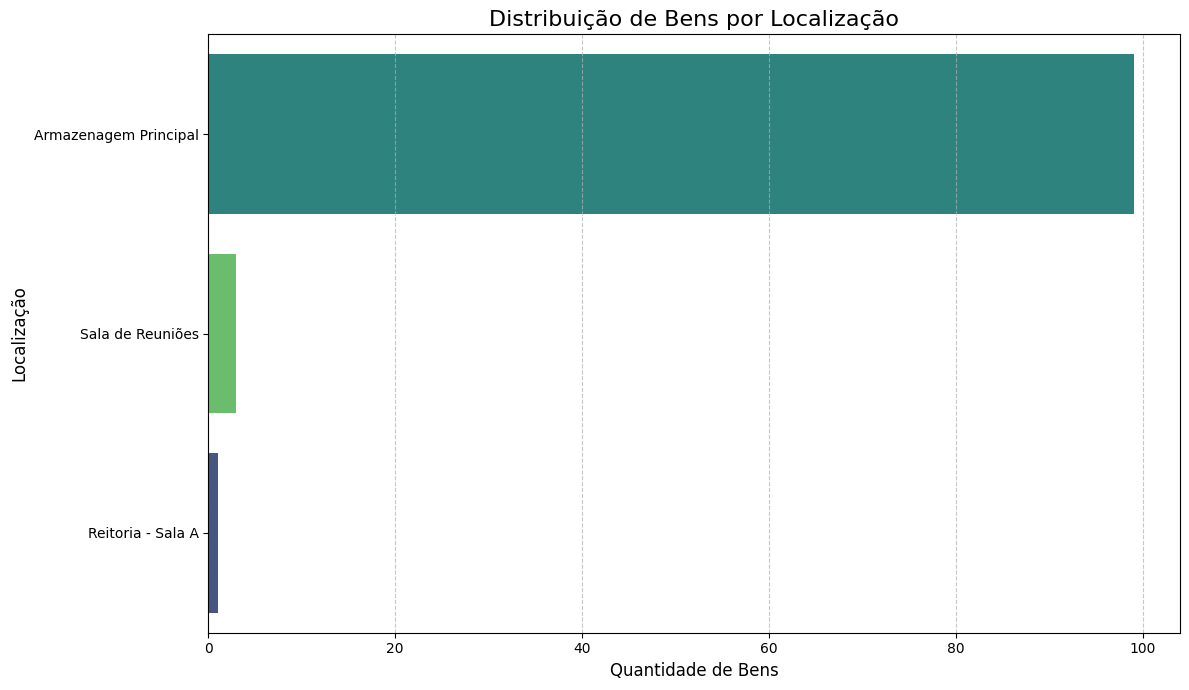

Gráfico 'bens_por_categoria_pizza.png' gerado e salvo com sucesso.


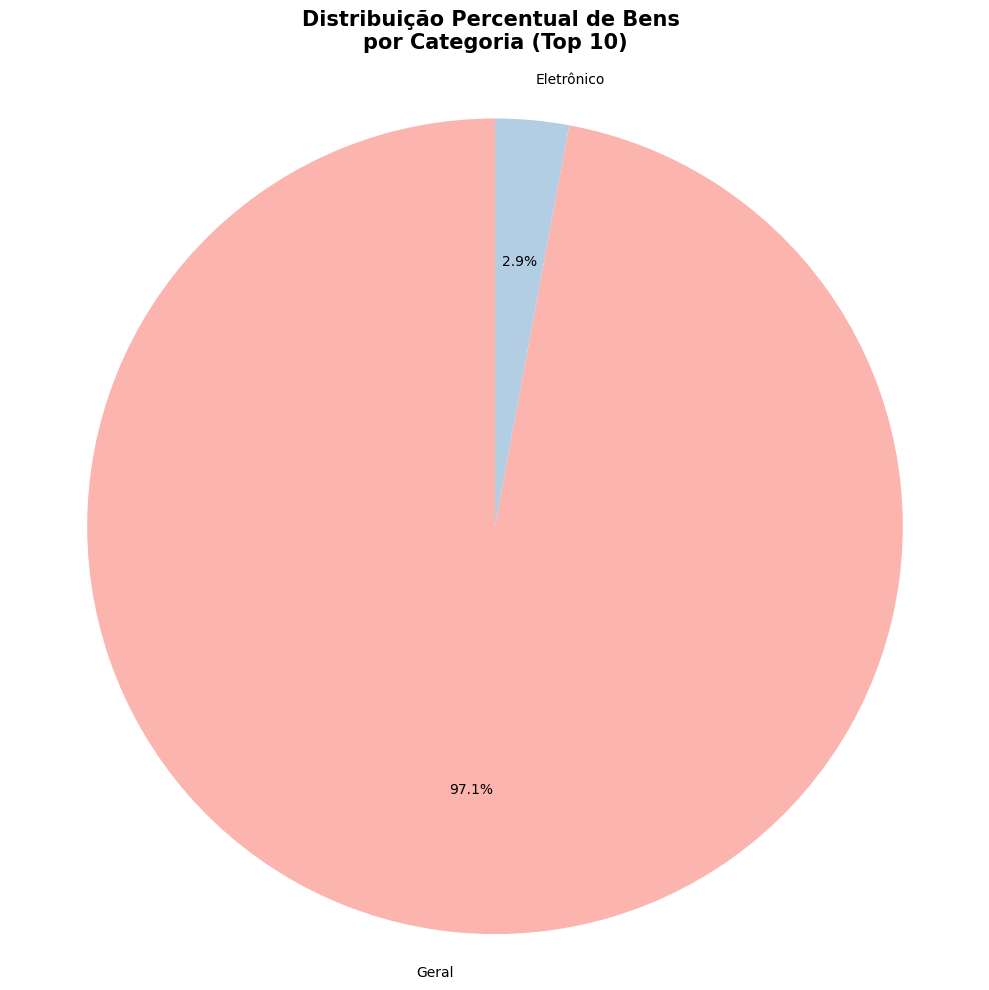

In [13]:
# Célula 13: Geração de Gráficos (Item 7)

# Item 7: Monte 2 gráficos diferentes e apresente os dados que achar pertinente.

def gerar_graficos(df):
    """
    Gera dois gráficos diferentes a partir do DataFrame para visualização dos dados.
    """
    if df.empty:
        print("AVISO: DataFrame vazio, não é possível gerar gráficos.")
        return

    print("\n--- GERANDO RELATÓRIOS VISUAIS ---")

    # Gráfico 1: Quantidade de Bens por Localização (Gráfico de Barras)
    plt.figure(figsize=(12, 7))
    sns.countplot(data=df, y='location', order=df['location'].value_counts().index, hue='location', legend=False, palette='viridis')
    plt.title('Distribuição de Bens por Localização', fontsize=16)
    plt.xlabel('Quantidade de Bens', fontsize=12)
    plt.ylabel('Localização', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('bens_por_localizacao.png') # Salva o gráfico como imagem
    print("Gráfico 'bens_por_localizacao.png' gerado e salvo com sucesso.")
    plt.show() # Exibe o gráfico no Jupyter

    # Gráfico 2: Distribuição de Bens por Categoria (Gráfico de Pizza)
    # Selecionar as 10 categorias mais comuns 
    top_categories = df['category'].value_counts().nlargest(10)
    if not top_categories.empty:
        plt.figure(figsize=(10, 10))
        colors = plt.get_cmap('Pastel1')(range(len(top_categories)))
        plt.pie(top_categories, labels=top_categories.index, autopct='%1.1f%%', startangle=90, colors=colors, pctdistance=0.65) # 'cmap' foi removido
        plt.title('Distribuição Percentual de Bens \npor Categoria (Top 10)\n', fontsize=15, fontweight='bold')
        plt.axis('equal') # Garante que o gráfico de pizza seja um círculo.
        plt.tight_layout()
        plt.savefig('bens_por_categoria_pizza.png') # Salva o gráfico como imagem
        print("Gráfico 'bens_por_categoria_pizza.png' gerado e salvo com sucesso.")
        plt.show() # Exibe o gráfico no Jupyter
    else:
        print("AVISO: Não há categorias suficientes para gerar o gráfico de pizza.")



# Executa a geração de gráficos, se houver dados para análise
# Certifique-se de que df_full_data_for_analysis esteja disponível e não vazio (definido na Célula 12)
if bens_collection is not None:
    try:
        # Tenta reobter o DataFrame caso o notebook tenha sido reiniciado ou a célula 12 não rodou
        # Em uma execução "Run All", df_full_data_for_analysis já estará populado.
        data_for_graphs = list(bens_collection.find({}, {"_id": 0}))
        if data_for_graphs:
            df_for_graphs = pd.DataFrame(data_for_graphs)
            gerar_graficos(df_for_graphs)
        else:
            print("\nNão foi possível gerar gráficos: Nenhuma dado disponível no MongoDB para análise.")
    except NameError:
        print("\nErro: 'df_full_data_for_analysis' não foi definido. Certifique-se de executar a Célula 12 (Análise Exploratória) primeiro.")
    except Exception as e:
        print(f"\nErro ao tentar gerar gráficos: {e}")

In [14]:
# Célula 14: Conclusão e Próximos Passos

print("\n--- DEMONSTRAÇÃO DO PROJETO FINAL CONCLUÍDA ---")
print("Todas as funcionalidades obrigatórias do trabalho foram demonstradas:")
print("- Conexão e importação de dados para MongoDB.")
print("- Operações CRUD (Inserção, Edição, Busca, Exclusão) de documentos.")
print("- Buscas com operadores e funções de agregação.")
print("- Análise exploratória de dados com Pandas.")
print("- Geração de relatórios visuais (gráficos).")

print("\nObrigado(a)!")


--- DEMONSTRAÇÃO DO PROJETO FINAL CONCLUÍDA ---
Todas as funcionalidades obrigatórias do trabalho foram demonstradas:
- Conexão e importação de dados para MongoDB.
- Operações CRUD (Inserção, Edição, Busca, Exclusão) de documentos.
- Buscas com operadores e funções de agregação.
- Análise exploratória de dados com Pandas.
- Geração de relatórios visuais (gráficos).

Obrigado(a)!
